# Agente de inversión autónomo (A3C-LSTM)

A lo largo de este notebook, voy a elaborar la guía de diseño del Agente de inversión autónomo, que describiré en las secciones siguientes:

## 1 Objetivo

El objetivo fundamental es diseñar un Agente inteligente que sea capaz de realizar inversiones en un par del mercado Forex (ej. EUR-USD). La idea general es diseñar una red neuronal tipo A3C (Asynchronous Advantage Actor-Critic) que por medio de aprendizaje por refuerzo (RL) sea capaz de aprender a realizar inversiones positivas.

#### Estados 

Por un lado, el Agente evaluará el estado del entorno, que estará formado por las siguiente variables:

- Predicciones recibidas del modelo predictivo LSTM diseñado en la fase anterior. Estas predicciones se componen de los precios HIGH y LOW estimado hasta la finalización de la sesión en curso. Como el predictor trabaja en gráficos de 1H, a las HH:00 predecirá los precios H,L de las (HH+1):00, es decir, el rango de variación que tendrá el precio hasta la finalización de la sesión actual.

- Estado de la cuenta. La cuenta se compone de diferentes variables, que dependen, de las operaciones realizadas y de los beneficios o pérdidas recibidos. Entre [estas variables](https://efxto.com/explicacion-apalancamiento-margen-balance-margen-libre-patrimonio) encontramos: 

 * Balance
 * Patrimonio
 * Margen
 * Margen Libre
 * Nivel de margen
 * Nº de operaciones abiertas LONG
 * Nº de operaciones abiertas SHORT
 * Beneficio flotante FLOAT_PL
 
- Precio en tiempo real. Son los precios OHLC del par en el que se está invirtiendo. Pueden ser obtenidos Tick a Tick, cada X segundos o en velas de 1M. La cadencia con la que se obtienen marcará la cadencia de ejecución del Agente inteligente, es decir, el Agente procesará una iteración cada vez que reciba un nuevo precio.


#### Acciones 

Por otro lado, y en un primer acercamiento, el Agente únicamente podrá realizar las siguientes acciones:

- Abrir posición en largo
- Mantener posición en largo
- Cerrar posición en largo
- Abrir posición en corto
- Mantener posición en corto
- Cerrar posición en corto

Por el momento, sólo se podrá realizar una única acción en cada iteración.

#### Función de evaluación

En todos los modelos de aprendizaje por refuerzo, es necesario proporcionar un mecanismo para valorar las decisiones del Agente en cada momento y así, con el tiempo, conseguir que éste sea capaz de aprender ciertos patrones de comportamiento que maximicen el rendimiento del mismo de acuerdo a la función de evaluación definida.

En este caso, el Agente tendrá una serie de limitaciones que estarán contempladas en dicha función de evaluación:

- Sólo se podrá tener abierta una única operación. Intentar abrir múltiples operaciones supondrá una penalización.
- Sólo se podrán realizar operaciones coherentes, es decir no se permitirá intentar cerrar una operación en corto si no hay ninguna abierta. De igual forma supondrá penalización.
- Las operaciones de entrada siempre se realizarán con un riesgo fijo del 1% del capital disponible.
- El stop-loss siempre se situará fuera del rango de predicción. Aún tengo que definir cómo abordarlo, aunque en siguientes aproximaciones, será el Agente el que estime dónde situar tanto el stop-loss como el take-profit. De igual forma, tendré que definir la estrategia para realizar el trailing-stop.

Por otro lado el objetivo principal del Agente, es maximir el Patrimonio cuando no hay operaciones abiertas (Balance=Patrimonio). 

Por lo tanto, las condiciones de premio-castigo serán las siguientes:

- La inactividad del Agente se penalizará. La penalización irá en función del tiempo transcurrido sin operar.
- El incremento de Patrimonio cuando (Balance=Patrimonio o Num_operaciones_abiertas=0 o FLOAT_PL=0) supondrá un premio directamente proporcional al beneficio obtenido
- Al contrario, un decremento del Patrimonio, supondrá un castigo directamente proporcional a la pérdida obtenida.

#### Entrenamiento episódico

Para realizar el entrenamiento del Agente, se disponen datos de predicciones (sesiones de 1 hora) y precios en tiempo real (sesiones de 1 minuto) desde diciembre del 2016 a diciembre del 2018.

Cada episodio contemplará la ejecución de cada tick del precio. La finalización del episodio terminará cuando se llegue al último tick disponible o cuando la cuenta esté cerca de entrar en 'default', es decir cuando reciba el primer 'margin call'.

## 2 Preparación

A continuación iré describiendo los pasos que he llevado a cabo para implementar el modelo neuronal comentado.

### Carga de librerías

En primer lugar cargamos las librerías que vamos a utilizar. Las más significativas son:

- Numpy, Pandas, Scikit-Learn, Matplotlib & Seaborn
- Keras como librería ML sobre Tensorflow
- Talib como librería fintech
- MyUtils, una librería propia donde tengo un poco de todo: desde implementaciones neuronales, partición de pares de entrenamiento y test, visualización, backup de archivos en disco, etc...

In [42]:
import sys
sys.path.append('../..')

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

In [43]:
import common.MyUtils as utils
print('Ready!')

Ready!


In [79]:
import A3C_Agent.A3C_LSTM as agent
print('Ready!')

Ready!


### Obtención del histórico de predicciones de la red LSTM

El notebook 'Generación de predicciones' realiza la predicción correspondiente y genera un archivo CSV con las mismas. A continuación, cargo dicho archivo y voy dándole el formato deseado.

Por otro lado es necesario también obtener los precios tick a tick en tiempo real para todo el rango de fechas del que dispongo predicciones, en este caso, utilizo datos OHLC de 1min obtenidos de Metatrader.


In [44]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = pd.read_csv('../../PredictiveNet/csv_data/EURUSD_H1_predictions.csv', sep=';', index_col=0)
df.index = pd.to_datetime(df.index)
print('Type of index values:',df.index.dtype)
df.head()


Type of index values: datetime64[ns]


,OPEN(t),HIGH(t),LOW(t),CLOSE(t),OUT_HIGH(t+1),OUT_LOW(t+1),TARGET_HIGH,TARGET_LOW,RMSE,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,TARGET_HIGH_PRICE,TARGET_LOW_PRICE,RMSE_PRICE
2001-01-02 21:00:00,0.9489,0.9517,0.9486,0.9508,0.000623,-0.000942,0.0004,-0.0016,0.000491,0.951423,0.949858,0.9512,0.9492,0.000491
2001-01-02 22:00:00,0.9506,0.9512,0.9492,0.9511,0.000627,-0.000964,0.0008,-0.0005,0.000350,0.951727,0.950136,0.9519,0.9506,0.000350
2001-01-02 23:00:00,0.9510,0.9519,0.9506,0.9507,0.000652,-0.000935,0.0007,-0.0001,0.000591,0.951352,0.949765,0.9514,0.9506,0.000591
2001-01-03 00:00:00,0.9508,0.9514,0.9506,0.9510,0.000596,-0.000916,0.0003,-0.0017,0.000592,0.951596,0.950084,0.9513,0.9493,0.000592
2001-01-03 01:00:00,0.9509,0.9513,0.9493,0.9498,0.000741,-0.000931,0.0014,-0.0002,0.000696,0.950541,0.948869,0.9512,0.9496,0.000696


Los features del dataframe de predicciones serán:

- PREDICT_HIGH_PRICE
- PREDICT_LOW_PRICE

In [45]:
df_predict = df[['PREDICT_HIGH_PRICE', 'PREDICT_LOW_PRICE']]
df_predict.head()

,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE
2001-01-02 21:00:00,0.951423,0.949858
2001-01-02 22:00:00,0.951727,0.950136
2001-01-02 23:00:00,0.951352,0.949765
2001-01-03 00:00:00,0.951596,0.950084
2001-01-03 01:00:00,0.950541,0.948869


Ahora cargo el archivo de precios de tiempo real. En este caso son precios OHLC en timeframe de 1 minuto

In [46]:
df_rt = utils.load_hist('../csv_data/EURUSD_M1.csv', sep=';', remove_weekends=True, freq="1min")
df_rt.head()

Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2016-12-01 00:01:00,1.05918,1.05918,1.05907,1.05907,1.059125,1.059107,1.059125,-0.00695,1,3,9.0,22000000.0,26.0
2016-12-01 00:02:00,1.05907,1.05909,1.05907,1.05908,1.059075,1.059080,1.059078,0.00001,2,3,6.0,8500000.0,25.0
2016-12-01 00:03:00,1.05908,1.05908,1.05901,1.05907,1.059075,1.059053,1.059060,-0.00001,3,3,3.0,2500000.0,25.0
2016-12-01 00:04:00,1.05901,1.05909,1.05901,1.05908,1.059045,1.059060,1.059047,0.00001,4,3,5.0,4500000.0,25.0
2016-12-01 00:05:00,1.05909,1.05916,1.05909,1.05913,1.059110,1.059127,1.059117,0.00005,5,3,9.0,1800000.0,25.0


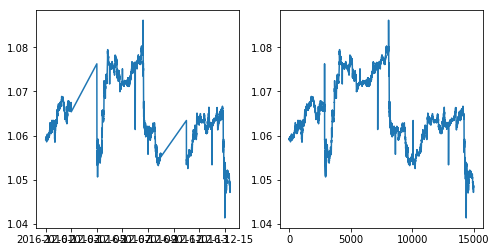

In [47]:
# Visualizo los 15000 primeros datos del precio de cierre (CLOSE) de dos formas:
# Utilizando el eje x como fechas espaciadas de hora en hora (se ve un ajuste a mitad de gráfico debido a un fin de semana)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_rt.CLOSE[0:15000])
# Utilizando los datos en bruto, con lo que dicha 'perturbación' ya no queda reflejada y por lo tanto podemos ver que los datos
# son válidos.
plt.subplot(1,2,2)
plt.plot(df_rt.CLOSE.values[0:15000])

Selecciono únicamente los features que utilizará el agente. Puesto que son precios en tiempo real, voy a tratar el precio de cierre como el precio de tick:

In [48]:
df_rt['TICK'] = df_rt['CLOSE']
df_rt.tail()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD,TICK
2018-11-30 22:55:00,1.13161,1.13171,1.13148,1.13166,1.131635,1.131617,1.131615,0.00006,1375,4,102.0,0.0,0.0,1.13166
2018-11-30 22:56:00,1.13166,1.13183,1.13166,1.13180,1.131730,1.131763,1.131738,0.00014,1376,4,37.0,0.0,0.0,1.13180
2018-11-30 22:57:00,1.13180,1.13197,1.13174,1.13197,1.131885,1.131893,1.131870,0.00017,1377,4,47.0,0.0,1.0,1.13197
2018-11-30 22:58:00,1.13197,1.13207,1.13190,1.13202,1.131995,1.131997,1.131990,0.00005,1378,4,86.0,0.0,0.0,1.13202
2018-11-30 22:59:00,1.13202,1.13219,1.13200,1.13215,1.132085,1.132113,1.132090,0.00013,1379,4,90.0,0.0,0.0,1.13215


Una vez obtenidos ambos precios, es necesario unificar sendos dataframe en uno único. Puesto que 'df_rt' tiene una mayor resolución, añadiré las columnas 'PREDICT_HIGH_PRICE' y 'PREDICT_LOW_PRICE' a éste, teniendo en cuenta que cada registro de 'df' permanece inalterable durante 1 sesión completa (1 hora)

In [49]:
df_rt['PREDICT_HIGH_PRICE'] = df_rt.apply(lambda row: df[df.index==row.name.replace(minute=0, second=0)]['PREDICT_HIGH_PRICE'].values[0] , axis=1)
df_rt['PREDICT_LOW_PRICE'] = df_rt.apply(lambda row: df[df.index==row.name.replace(minute=0, second=0)]['PREDICT_LOW_PRICE'].values[0] , axis=1)
df_rt.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD,TICK,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE
2016-12-01 00:01:00,1.05918,1.05918,1.05907,1.05907,1.059125,1.059107,1.059125,-0.00695,1,3,9.0,22000000.0,26.0,1.05907,1.06027,1.058632
2016-12-01 00:02:00,1.05907,1.05909,1.05907,1.05908,1.059075,1.059080,1.059078,0.00001,2,3,6.0,8500000.0,25.0,1.05908,1.06027,1.058632
2016-12-01 00:03:00,1.05908,1.05908,1.05901,1.05907,1.059075,1.059053,1.059060,-0.00001,3,3,3.0,2500000.0,25.0,1.05907,1.06027,1.058632
2016-12-01 00:04:00,1.05901,1.05909,1.05901,1.05908,1.059045,1.059060,1.059047,0.00001,4,3,5.0,4500000.0,25.0,1.05908,1.06027,1.058632
2016-12-01 00:05:00,1.05909,1.05916,1.05909,1.05913,1.059110,1.059127,1.059117,0.00005,5,3,9.0,1800000.0,25.0,1.05913,1.06027,1.058632


A continuación selecciono los precios en tiempo real y las predicciones como 'variables de estado' relativas al precio

In [64]:
df_a3c = df_rt[['TICK', 'PREDICT_HIGH_PRICE', 'PREDICT_LOW_PRICE']].copy()
df_a3c.head()

,TICK,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE
2016-12-01 00:01:00,1.05907,1.06027,1.058632
2016-12-01 00:02:00,1.05908,1.06027,1.058632
2016-12-01 00:03:00,1.05907,1.06027,1.058632
2016-12-01 00:04:00,1.05908,1.06027,1.058632
2016-12-01 00:05:00,1.05913,1.06027,1.058632


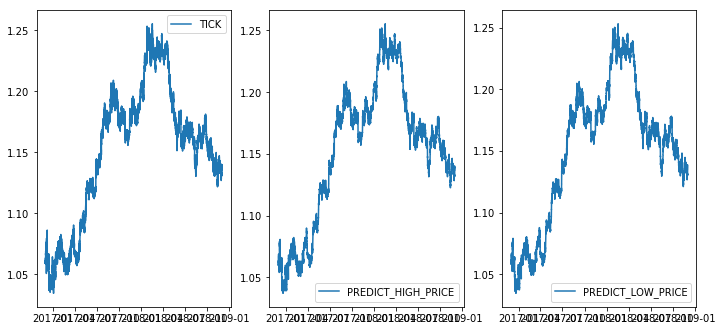

In [65]:
# Visualizo todas las columnas
rows = (df_a3c.shape[1] / 3) + 1
plt.figure(figsize = (16,12))
for c in df_a3c.columns:
  i = df_a3c.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df_a3c[c])
  plt.legend([c])
  

A continuación voy a añadir las columnas relativas al estado de la cuenta y para ello las inicializo a sus valores por defecto (0.0)

In [66]:
df_a3c['ACC_BALANCE'] = 0.0
df_a3c['ACC_EQUITY'] = 0.0
df_a3c['ACC_MARGIN'] = 0.0
df_a3c['ACC_FREE_MARGIN'] = 0.0
df_a3c['ACC_MARGIN_LEVEL'] = 0.0
df_a3c['ACC_LONG_OPENED'] = 0.0
df_a3c['ACC_SHORT_OPENED'] = 0.0
df_a3c['ACC_FLOAT_PL'] = 0.0
df_a3c.head()


,TICK,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,ACC_BALANCE,ACC_EQUITY,ACC_MARGIN,ACC_FREE_MARGIN,ACC_MARGIN_LEVEL,ACC_LONG_OPENED,ACC_SHORT_OPENED,ACC_FLOAT_PL
2016-12-01 00:01:00,1.05907,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:02:00,1.05908,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:03:00,1.05907,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:04:00,1.05908,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:05:00,1.05913,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora incluyo las columnas relativas a las salidas

In [67]:
df_a3c['OUT_OPEN_LONG'] = 0.0
df_a3c['OUT_HOLD_LONG'] = 0.0
df_a3c['OUT_CLOSE_LONG'] = 0.0
df_a3c['OUT_OPEN_SHORT'] = 0.0
df_a3c['OUT_HOLD_SHORT'] = 0.0
df_a3c['OUT_CLOSE_SHORT'] = 0.0
df_a3c.head()


,TICK,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,ACC_BALANCE,ACC_EQUITY,ACC_MARGIN,ACC_FREE_MARGIN,ACC_MARGIN_LEVEL,ACC_LONG_OPENED,ACC_SHORT_OPENED,ACC_FLOAT_PL,OUT_OPEN_LONG,OUT_HOLD_LONG,OUT_CLOSE_LONG,OUT_OPEN_SHORT,OUT_HOLD_SHORT,OUT_CLOSE_SHORT
2016-12-01 00:01:00,1.05907,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:02:00,1.05908,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:03:00,1.05907,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:04:00,1.05908,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 00:05:00,1.05913,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Una vez que tengo todo creado, voy a separar el dataframe en 2 slices: entrada y salida

In [68]:
df_a3c_in  = df_a3c[['TICK','PREDICT_HIGH_PRICE','PREDICT_LOW_PRICE','ACC_BALANCE','ACC_EQUITY','ACC_MARGIN','ACC_FREE_MARGIN','ACC_MARGIN_LEVEL','ACC_LONG_OPENED','ACC_SHORT_OPENED','ACC_FLOAT_PL']]
df_a3c_out = df_a3c[['OUT_OPEN_LONG','OUT_HOLD_LONG','OUT_CLOSE_LONG','OUT_OPEN_SHORT','OUT_HOLD_SHORT','OUT_CLOSE_SHORT']]

In [69]:
df_a3c_in.head(1)

,TICK,PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE,ACC_BALANCE,ACC_EQUITY,ACC_MARGIN,ACC_FREE_MARGIN,ACC_MARGIN_LEVEL,ACC_LONG_OPENED,ACC_SHORT_OPENED,ACC_FLOAT_PL
2016-12-01 00:01:00,1.05907,1.06027,1.058632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
df_a3c_out.head(1)

,OUT_OPEN_LONG,OUT_HOLD_LONG,OUT_CLOSE_LONG,OUT_OPEN_SHORT,OUT_HOLD_SHORT,OUT_CLOSE_SHORT
2016-12-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0


En este punto, ya dispongo de un dataframe de trabajo con el que alimentar al agente A3C y en el que ir guardando las acciones realizadas para un posterior análisis.

La siguiente fase, es la definición del Agente.

## 3 Diseño del Agente inteligente

Como he dicho anteriormente, voy a utilizar un modelo de red neuronal denominado A3C y de igual forma que en el Predictor LSTM, voy a utilizar Keras como frontend de Tensorflow.

Sin embargo, como ya iré detallando a lo largo de esta guía, será necesario realizar algunos ajustes directamente en Tensorflow con lo que la portabilidad del modelo a otro framework ya no será directa.

Según avance en la descripción del modelo, iré adjuntando referencias a papers, tutoriales y demás que me han sido de utilidad para definir este modelo.

### Arquitectura A3C-LSTM

Después de leer varios artículos, canales de [youtube](https://www.youtube.com/watch?v=zSuLI3Jbh5w&list=PLdjRselWvmstxslW2M7CNSC8PplkxNYpm) y demás, di con este artículo [Asynchronous methods of Reinforcement Learning](https://arxiv.org/pdf/1602.01783.pdf). A grandes rasgos hace un estudio de diferentes modelos de aprendizaje por refuerzo, en el que se investigaban los comportamientos de éstos ante diferentes problemas. El resultado es que los modelos A3C LSTM son los que mejor se comportan de forma general.

Por un lado tiene la ventaja de ser un modelo A3C que ha demostrado ser más rápido que los DQN y por otro, al contar internamente con varias capas LSTM le hace ideal para la resolución de problemas que dependen de variables que pueden expresarse como series temporales.

En mi caso, este modelo se adpata perfectamente y por lo tanto es el que voy a implementar.

Para ello voy a utilizar recursos de varios github, tutoriales y notebooks que he ido filtrando y que paso a comentar:

- [Let's make an A3C](https://jaromiru.com/2017/02/16/lets-make-an-a3c-theory/) de jaromiru. Explica detalladamente la teoría y posteriormente realiza una implementación completa [aquí](https://github.com/jaromiru/AI-blog/blob/master/CartPole-A3C.py)

- [Idem que el anterior](https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296) de Raymond Yuan, también dispone de la implementación en [github](https://github.com/tensorflow/models/blob/master/research/a3c_blogpost/a3c_cartpole.py)

- [Aquí](https://towardsdatascience.com/advanced-reinforcement-learning-6d769f529eb3) una explicación muy buena de los modelos DQN y A3C/A2C. Pero sin implementación.

- [Aquí](https://towardsdatascience.com/a-blundering-guide-to-making-a-deep-actor-critic-bot-for-stock-trading-c3591f7e29c2) una descripción de un bot de inversión en acciones basado en un modelo actor-critic. Y [aquí](https://github.com/tomgrek/RL-stocktrading/blob/master/Finance%20final.ipynb) el notebook de la implementación.

- [Aquí](https://github.com/liampetti/A3C-LSTM) una explicación e implementación del modelo A3C-LSTM de nuevo en el 'Cartpole'.

- [Aquí](https://github.com/MatheusMRFM/A3C-LSTM-with-Tensorflow) otra implementación A3C-LSTM en tensorflow.


### Entorno de juego

La plataforma por defecto en la que se evalúan la gran mayoría de modelos RL es [Gym](https://gym.openai.com/) de OpenAI. Esta plataforma proporciona una API para que el modelo RL interactue con el entorno de juego: recibiendo el estado actual y enviando las acciones a realizar.

Puesto que esta plataforma está tan extendida, es interesante investigar la forma de definir mi problema como un nuevo `Entorno` compatible con los que se definen en Gym. Esto es posible llevarlo a cabo, ya que Gym proporciona un interfaz común para poder crear nuevos entornos de juego, siendo todos ellos compatibles entre si.

En [este enlace](https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym) se detalla el proceso de crear un nuevo 'Environment' compatible con Gym y de hecho, registrable en el propio framework.

Este será el primer paso a realizar, antes de llevar a cabo la implementación del agente. Por otro lado, ya existen varios desarrollos en esta línea, y quizás pueda aprovechar algo de ellos, si no utilizarlos tal cual:

- [Trading-Gym](https://github.com/thedimlebowski/Trading-Gym)
- [gym-trading](https://github.com/hackthemarket/gym-trading)
- [Sairen](https://doctorj.gitlab.io/sairen/)

**`Trading-Gym`** es un entorno más simple pero contempla un renderizado simple

**`gym-trading`** es un entorno algo más elaborado, ya que obtiene datos en tiempo real de Quandl, pero no renderiza en tiempo real el juego en si.

**`Sairen`** es el entorno más serio, basado en IB.

Viendo ambos entornos, voy a estudiar una implementación en dos fases:

##### 1ª Fase

En esta fase, clonaré el repo `gym-trading` y lo modificaré para que los datos de precio en tiempo real OHLC los proporcione un data-feed asociado a una callback. De esta forma, podrá tomar los datos de Quandl, de otro broker o los podré proporcionar yo directamente desde el dataframe `df_a3c_in`.

Clonaré el repo `Trading-Gym` para integrar el rendering, de forma que a lo largo del juego se pueda visualizar el precio actual TICK, las predicciones HIGH,LOW, las operaciones realizadas por el agente y una barra indicando el valor de las variables de estado (balance, equity, margin, ...)

Usaré la documentación de `Sairen` para ver la forma en que se proporcionan las recompensas.


##### 2ª Fase

Esta fase se corresponderá con la fase de backtesting. En este caso, el Environment, creará una conexión ZMQ con el terminal de Metatrader-Darwinex. Cuando la simulación se inicie en Metatrader, el Environment comenzará a recibir precios OHLC y el estado de la cuenta. Dichas variables se obtendrán mediante `env.reset()` y `env.step()`.



